In [1]:
import sys 
sys.path.append('../..')

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.functions import get_normalized_list

In [3]:
xlsx_file = pd.ExcelFile('../../input/БОГРАД_PISY.xlsx')
trees = ['pisy_01a', 'pisy_01b', 'pisy_02a', 'pisy_03a', 'pisy_07a', 'pisy_12b', 'pisy_14a']
columns = {_:f'D{__}' if __<16 else f'CWT{__-15}' for _, __ in zip(range(2,32), range(1,31))}
columns[0] = 'Tree'
columns[1] = 'Year'

In [4]:
dataframes = []
norm_to = 15

for tree in trees:
    df = xlsx_file.parse(tree)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna(axis=0)

    norm_traches = dict()
    for year in set(df['Год']):
        norm_traches[int(year)] = [tree, int(year)] + get_normalized_list(list(df[df['Год']==year]['Dmean']), norm_to)+ get_normalized_list(list(df[df['Год']==year]['CWTmean']), norm_to)
    
    dataframes += [pd.DataFrame(norm_traches).transpose().rename(columns=columns).reset_index(drop=True)]

df = pd.concat(dataframes).reset_index(drop=True)

In [6]:
for l in range(1,16):
    df[f'L{l}'] = df[f'D{l}'] - 2  * df[f'CWT{l}']

In [10]:
mean_objects_years = dict()

for year in set(df['Year']):
    temp_data = df[df['Year']==year]
    if len(temp_data) > 3:
        mean_objects_years[year] = temp_data.mean()[1:]


mean_objects_trees = dict()

for tree in set(df['Tree']):
    mean_objects_trees[tree] = df[df['Tree']==tree].mean()[1:]

In [11]:
global_mean = df.mean()[1:]

In [21]:
quotient_deviation_df_A = []

_columns = {_:f'D{_}' if _ < norm_to + 1 else f'CWT{_ - norm_to}' for _ in  range(1, norm_to * 2 + 1)}
for l in range(norm_to * 2 + 1,norm_to * 2 + 16):
    _columns[l] = f'L{l-30}'
_columns[0] = 'Year'

for year, mean_obj in mean_objects_years.items():
    quotient_deviation_df_A += [[year] + list(mean_obj/global_mean)]

quotient_deviation_df_A = pd.DataFrame(quotient_deviation_df_A).rename(columns=_columns)

In [22]:
qd_df_B = []

quotient_deviation_df_B = dict()


for _, row in df.iterrows():
    qd_df_B += [[row[0], row[1]] + list(row[2:] / mean_objects_trees[row[0]])]

qd_df_B = pd.DataFrame(qd_df_B).rename(columns=columns)

for year in set(df['Year']):
    temp_data_q = qd_df_B[qd_df_B['Year']==year]
    if len(temp_data_q) > 3:
        quotient_deviation_df_B[year] = temp_data_q.mean()[1:]

quotient_deviation_df_B = pd.DataFrame(quotient_deviation_df_B).transpose()

In [24]:
a_classified = pd.read_excel('../../input/quotient_deviation_df_A_CLASSIFIED.xlsx')

In [28]:
quotient_deviation_df_A['Class 4'] = a_classified['Class 4']

Class 1, 38 elements
Class 2, 64 elements
Class 3, 48 elements
Class 4, 52 elements


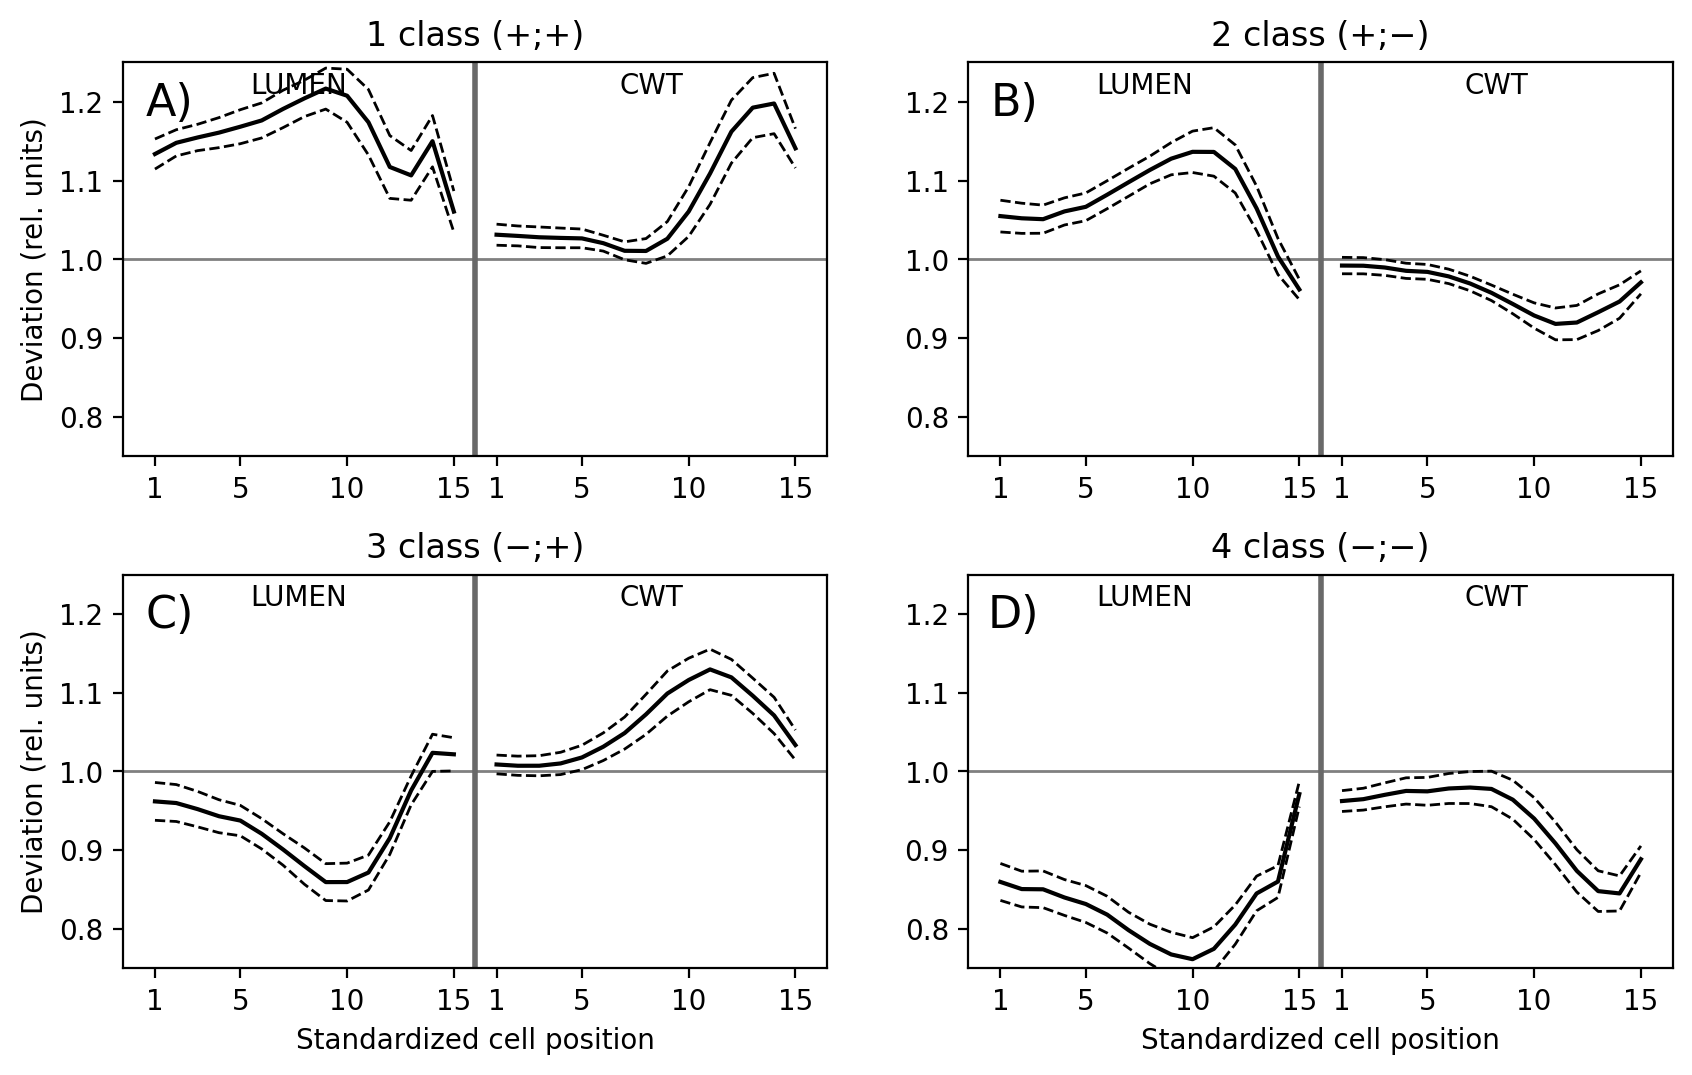

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6), dpi=200)
plt.subplots_adjust(hspace=0.3)

subplot_labels = ['A)', 'B)', 'C)', 'D)']

for i in range(4):
    selected = quotient_deviation_df_A[quotient_deviation_df_A['Class 4']==i]
    print(f'Class {i+1}, {len(selected)} elements')

    ax[int(i>1), i%2].axhline(y=1, c='grey', linewidth=1)
    ax[int(i>1), i%2].axvline(x=16, c='dimgrey', linewidth=2 )

    d_mean = np.array(selected.mean()[31:31+15])
    d_conf_interfal = 1.96* np.array(selected.std()[1:16])/ (len(selected)**0.5)
    ax[int(i>1), i%2].plot(range(1,16), d_mean + d_conf_interfal, c='k', linestyle='--', linewidth=1)
    ax[int(i>1), i%2].plot(range(1,16), d_mean - d_conf_interfal, c='k', linestyle='--', linewidth=1)
    ax[int(i>1), i%2].plot(range(1,16), d_mean, c='k')

    cwt_mean = np.array(selected.mean()[16:31])
    cwt_conf_interfal = 1.96* np.array(selected.std()[16:31])/ (len(selected)**0.5)
    ax[int(i>1), i%2].plot(range(17,32), cwt_mean + cwt_conf_interfal, c='k', linestyle='--', linewidth=1)
    ax[int(i>1), i%2].plot(range(17,32), cwt_mean - cwt_conf_interfal, c='k', linestyle='--', linewidth=1)
    ax[int(i>1), i%2].plot(range(17,32), cwt_mean, c='k')

    ax[int(i>1), i%2].set_ylim([0.75, 1.25])
    ax[int(i>1), i%2].set_xticks([1, 5, 10, 15, 17, 21, 26, 31])
    ax[int(i>1), i%2].set_xticklabels([1, 5, 10, 15, 1, 5, 10, 15])
    ax[int(i>1), i%2].set_title(f"{i+1} class ({'−' if int(i>1) else '+'};{'−' if i%2 else '+'})")
    ax[int(i>1), i%2].text(0.25, 0.94, 'LUMEN', horizontalalignment='center', verticalalignment='center', transform=ax[int(i>1), i%2].transAxes)
    ax[int(i>1), i%2].text(0.75, 0.94, 'CWT', horizontalalignment='center', verticalalignment='center', transform=ax[int(i>1), i%2].transAxes)
    ax[int(i>1), i%2].text(0.1, 0.95, subplot_labels[i], transform=ax[int(i>1), i%2].transAxes, fontsize=16, va='top', ha='right')



ax[0, 0].set_ylabel("Deviation (rel. units)")
ax[1, 0].set_ylabel("Deviation (rel. units)")
ax[1, 0].set_xlabel("Standardized cell position")
ax[1, 1].set_xlabel("Standardized cell position")

plt.savefig(f'../../output/Fig 4 LUMEN.png', dpi=300)
plt.show()